In [ ]:
import os
import sys
path = os.getcwd()
print("Old path:", path)
path = path.split("/")
path = path[: path.index("ABC-SBI") + 1]
path = "/".join(path)
print("New path:", path)
os.chdir(path)
sys.path.append(path)
from functions.simulation import (
    get_dataset,
    NRE_corrected_posterior_sample,
    NRE_posterior_sample,
)
from functions.training import train_loop
from functions.plots import plot_metric_for_a_dataset, plot_metric_for_many_datasets, plot_posterior_comparison
from functions.metrics import evaluate_metrics
from functions.save import create_csv_for_a_dataset, create_pickle_for_a_dataset
from jax import random, jit, vmap
from sklearn.model_selection import train_test_split
import time
from scipy.stats import norm
import numpy as np
import jax.numpy as jnp

def ABC_gauss_single(key, true_data, epsilon):
    key, key_xbar = random.split(key)
    xbar = random.truncated_normal(key_xbar, lower = (jnp.mean(true_data)-jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)), upper = (jnp.mean(true_data)+jnp.sqrt(epsilon)-MU0)/jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)))*jnp.sqrt(SIGMA0**2+SIGMA**2/len(true_data)) + MU0
    dist = (jnp.mean(true_data)-xbar)**2
    key, key_z = random.split(key)
    z = random.normal(key_z, (len(true_data),))*SIGMA
    z = z-jnp.mean(z)+xbar
    key, key_mu = random.split(key)
    mu = random.normal(key_mu, (1,))*SIGMA/jnp.sqrt(len(true_data)) + xbar
    return z, mu, dist


def ABC_gauss(key, true_data, epsilon, N_ABC):
    keys = random.split(key, N_ABC+1)
    zs, mus, dists = vmap(jit(ABC_gauss_single), (0, None, None))(keys[1:], true_data, epsilon)
    return zs, mus, dists, keys[0]



def get_dataset_gauss(key, n_points, prior_simulator, data_simulator, discrepancy, epsilon, true_data, index_marginal):
    n_points = n_points//2
    zs, thetas, dists, key = ABC_gauss(key, true_data, epsilon, n_points)
    thetas = thetas[:, index_marginal][:,None]
    key, key_perm = random.split(key)
    thetas_prime = thetas[random.permutation(key_perm, jnp.arange(n_points))]
    zs = jnp.concatenate([zs, zs], axis=0)
    thetas = jnp.concatenate([thetas, thetas_prime], axis=0)
    ys = jnp.append(jnp.zeros(n_points), jnp.ones(n_points)).astype(int)
    Xs = jnp.concatenate([thetas, zs], axis=1)
    return Xs, ys, dists, key




@jit
def prior_simulator(key):
    return random.normal(key, (1,)) * SIGMA0 + MU0


@jit
def data_simulator(key, theta):
    return (random.normal(key, (N_DATA,)) * SIGMA + theta).astype(float)


@jit
def discrepancy(y, y_true):
    return (jnp.mean(y) - jnp.mean(y_true)) ** 2


def true_posterior_sample(key, TRUE_DATA, N_SAMPLE):
    mu_post = (MU0 * SIGMA**2 + SIGMA0**2 * jnp.sum(TRUE_DATA)) / (
        SIGMA0**2 * len(TRUE_DATA) + SIGMA**2
    )
    sigma2_post = 1 / (1 / SIGMA0**2 + len(TRUE_DATA) / SIGMA**2)
    return random.normal(key, (N_SAMPLE,)) * np.sqrt(sigma2_post) + mu_post


key = random.PRNGKey(0)

N_DATA = 100
N_KDE = 10000
N_POINTS = 500000
N_SAMPLE = 10000
N_SAMPLES = 1
N_DATASETS = 10
N_EPOCHS = 10
N_GRID = 10000
# ALPHAS = [1.0, .9, .5,.1,.05,.01,.005,.001] 
ALPHAS = [1., .1, .01, .001, .0001]
SIGMA = 1.0
MU0, SIGMA0 = 0.0, 10.0

PRIOR_DIST = norm(loc=MU0, scale=SIGMA0)
INDEX_MARGINAL = 0

MODEL_ARGS = {"SIGMA": SIGMA}
PRIOR_ARGS = {"MU0": MU0, "SIGMA0": SIGMA0}


PATH_RESULTS = (
    os.getcwd()
    + "/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/clean_results/sigma0_{}/".format(int(SIGMA0))
)
PATH_FIGURES = PATH_RESULTS + "figures/"
PATH_POSTERIORS = PATH_FIGURES + "posterior_check/
PATH_PICKLES = PATH_RESULTS + "pickles/"
PATH_CSV = PATH_RESULTS + "csv/"
 
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)
if not os.path.exists(PATH_FIGURES):
    os.makedirs(PATH_FIGURES)
if not os.path.exists(PATH_PICKLES):
    os.makedirs(PATH_PICKLES)
if not os.path.exists(PATH_CSV):
    os.makedirs(PATH_CSV)
if not os.path.exists(PATH_POSTERIORS):
    os.makedirs(PATH_POSTERIORS)


LEARNING_RATE = 0.001
PATIENCE = 7
COOLDOWN = 0
FACTOR = 0.5
RTOL = 1e-4
ACCUMULATION_SIZE = 200
LEARNING_RATE_MIN = 1e-6

BATCH_SIZE = 256
NUM_BATCH = 1024
NUM_CLASSES = 2
HIDDEN_SIZE = 256
NUM_LAYERS = 2
WDECAY = 0.001


def ABC_NRE(
    key,
    N_POINTS,
    prior_simulator,
    data_simulator,
    discrepancy,
    TRUE_DATA,
    EPSILON,
    index_marginal=0,
):
    key, key_data = random.split(key)
    time_start = time.time()
    print("Simulation of the training dataset...")
    X, y, dists, key = get_dataset_gauss(
        key_data,
        N_POINTS,
        prior_simulator,
        data_simulator,
        discrepancy,
        EPSILON,
        TRUE_DATA,
        index_marginal,
    )

    key, key_split = random.split(key)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=np.random.RandomState(key_split)
    )
    time_simulations = time.time() - time_start

    N_POINTS_TRAIN = len(X_train)
    N_POINTS_TEST = len(X_test)

    print("Training the neural network...")
    params, train_accuracy, train_losses, test_accuracy, test_losses, key = train_loop(
        key,
        N_EPOCHS,
        NUM_LAYERS,
        HIDDEN_SIZE,
        NUM_CLASSES,
        BATCH_SIZE,
        NUM_BATCH,
        LEARNING_RATE,
        WDECAY,
        PATIENCE,
        COOLDOWN,
        FACTOR,
        RTOL,
        ACCUMULATION_SIZE,
        LEARNING_RATE_MIN,
        prior_simulator,
        data_simulator,
        discrepancy,
        true_data=TRUE_DATA,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        N_POINTS_TRAIN=N_POINTS_TRAIN,
        N_POINTS_TEST=N_POINTS_TEST,
        epsilon=EPSILON,
        verbose=True,
    )
    time_training = time.time() - time_simulations

    return (
        X,
        y,
        dists,
        params,
        train_accuracy,
        train_losses,
        test_accuracy,
        test_losses,
        key,
        time_simulations,
        time_training,
    )
    


def for_an_epsilon(
    i_dataset,
    alpha,
    key,
    N_POINTS,
    prior_simulator,
    data_simulator,
    discrepancy,
    TRUE_DATA,
    EPSILON,
    PRIOR_DIST,
    N_GRID,
    N_KDE,
    index_marginal=0,
):
    print("\n---------------------------------\nDATASET {} ALPHA {}\n---------------------------------".format(i_dataset, alpha))
    key, key_nre, key_kde, key_evaluate = random.split(key, 4)
    (
        X,
        y,
        dists,
        params,
        train_accuracy,
        train_losses,
        test_accuracy,
        test_losses,
        key,
        time_simulations,
        time_training,
    ) = ABC_NRE(
        key_nre, 
        N_POINTS,
        prior_simulator,
        data_simulator,
        discrepancy,
        TRUE_DATA,
        EPSILON,
        index_marginal,
    )
    THETAS_ABC = X[:, 0]
    print("Plotting the posterior...")
    plot_posterior_comparison(params, TRUE_DATA, THETAS_ABC, PRIOR_DIST, true_posterior_pdf=true_posterior_pdf, show = True, N_GRID = 10000, file_name = PATH_POSTERIORS + "{}_alpha_{}.png".format(i_dataset, alpha), N_KDE = 10000)

    
    METRICS_ABC_ij, METRICS_NRE_ij, METRICS_CORRECTED_NRE_ij, time_eval = evaluate_metrics(key_evaluate, TRUE_DATA, params, THETAS_ABC, PRIOR_DIST, N_GRID, N_SAMPLE, N_SAMPLES, true_posterior_sample, N_KDE)
    return (
        dists,
        params,
        train_accuracy,
        train_losses,
        test_accuracy,
        test_losses,
        time_simulations,
        time_training,
        time_eval,
        METRICS_ABC_ij,
        METRICS_NRE_ij,
        METRICS_CORRECTED_NRE_ij,
    )


def for_a_dataset(
    i_dataset,
    key,
    N_POINTS,
    prior_simulator,
    data_simulator,
    discrepancy,
    ALPHAS,
    PRIOR_DIST,
    index_marginal=0,
):  
    print("\n---------------------------------\nDATASET {}\n---------------------------------".format(i_dataset))
    PARAMS_i, TEST_ACCURACY_i, TRAIN_ACCURACY_i, TEST_LOSSES_i, TRAIN_LOSSES_i = (
        {},
        {},
        {},
        {},
        {},
    )
    TIME_SIMULATIONS_i, TIME_TRAINING_i, TIME_EVAL_i = {}, {}, {}
    METRICS_ABC_i, METRICS_NRE_i, METRICS_CORRECTED_NRE_i = {}, {}, {}

    key, key_theta, key_data = random.split(key, 3)
    TRUE_THETA = prior_simulator(key_theta)
    TRUE_DATA = data_simulator(key_data, TRUE_THETA)
    key, key_epsilon = random.split(key)
    time_iterations = {}
    
    EPSILONS_i = {1.0: np.inf}
    for alpha in ALPHAS:
        time_iteration = time.time()
        EPSILON = EPSILONS_i[alpha]
        key, key_epsilon = random.split(key_epsilon)
        (
            dists,
            params,
            train_accuracy,
            train_losses,
            test_accuracy,
            test_losses,
            time_simulations,
            time_training,
            time_eval,
            METRICS_ABC_ij,
            METRICS_NRE_ij,
            METRICS_CORRECTED_NRE_ij,
        ) = for_an_epsilon(
            i_dataset,
            alpha,
            key_epsilon,
            N_POINTS,
            prior_simulator,
            data_simulator,
            discrepancy,
            TRUE_DATA,
            EPSILON,
            PRIOR_DIST,
            N_GRID,
            N_KDE,
            index_marginal,
        )

        if alpha == 1:
            for alpha_not_1 in ALPHAS[1:]:
                EPSILONS_i[alpha_not_1] = float(jnp.quantile(dists, alpha_not_1))

        PARAMS_i[alpha] = params
        TEST_ACCURACY_i[alpha] = test_accuracy
        TRAIN_ACCURACY_i[alpha] = train_accuracy
        TEST_LOSSES_i[alpha] = test_losses
        TRAIN_LOSSES_i[alpha] = train_losses
        TIME_SIMULATIONS_i[alpha] = time_simulations
        TIME_TRAINING_i[alpha] = time_training
        TIME_EVAL_i[alpha] = time_eval
        METRICS_ABC_i[alpha] = METRICS_ABC_ij
        METRICS_NRE_i[alpha] = METRICS_NRE_ij
        METRICS_CORRECTED_NRE_i[alpha] = METRICS_CORRECTED_NRE_ij
        time_iterations[alpha] = time.time() - time_iteration
        
    plot_metric_for_a_dataset("C2ST", ALPHAS, METRICS_ABC_i, METRICS_NRE_i, METRICS_CORRECTED_NRE_i, N_SAMPLES, PATH_FIGURES + "c2st_{}.png".format(i_dataset), show = False)
    plot_metric_for_a_dataset("RS_stat", ALPHAS, METRICS_ABC_i, METRICS_NRE_i, METRICS_CORRECTED_NRE_i, N_SAMPLES, PATH_FIGURES + "ranksums_{}.png".format(i_dataset), show = False)
    create_csv_for_a_dataset(i_dataset, ALPHAS, TEST_ACCURACY_i, TRAIN_ACCURACY_i, TEST_LOSSES_i, TRAIN_LOSSES_i, TIME_SIMULATIONS_i, TIME_TRAINING_i, TIME_EVAL_i, METRICS_ABC_i, METRICS_NRE_i, METRICS_CORRECTED_NRE_i, TRUE_DATA, TRUE_THETA, PATH_CSV + "dataset_{}.csv".format(i_dataset))
    create_pickle_for_a_dataset(ALPHAS, PARAMS_i, METRICS_ABC_i, METRICS_NRE_i, METRICS_CORRECTED_NRE_i, TRUE_DATA, TRUE_THETA, TIME_SIMULATIONS_i, TIME_TRAINING_i, TIME_EVAL_i, MODEL_ARGS, PRIOR_ARGS, PATH_PICKLES + "dataset_{}.pkl".format(i_dataset))
        

    return (
        PARAMS_i,
        TEST_ACCURACY_i,
        TRAIN_ACCURACY_i,
        TEST_LOSSES_i,
        TRAIN_LOSSES_i,
        TIME_SIMULATIONS_i,
        TIME_TRAINING_i,
        TIME_EVAL_i,
        METRICS_ABC_i,
        METRICS_NRE_i,
        METRICS_CORRECTED_NRE_i,
        TRUE_DATA,
        TRUE_THETA,
    )


PARAMS = {}
TEST_ACCURACY = {}
TRAIN_ACCURACY = {}
TEST_LOSSES = {}
TRAIN_LOSSES = {}

TIME_SIMULATIONS = {}
TIME_TRAINING = {}
TIME_EVAL = {}
EPSILONS = {}

TRUE_DATAS = {}
TRUE_THETAS = {}

METRICS_ABC = {}
METRICS_NRE = {}
METRICS_CORRECTED_NRE = {}


   
    

Old path: /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma
New path: /Users/antoineluciano/Documents/Recherche/ABC-SBI


/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(



---------------------------------
DATASET 0
---------------------------------

---------------------------------
DATASET 0 ALPHA 1.0
---------------------------------
Simulation of the training dataset...
Training the neural network...
Initial accuracy: 47.21%, Initial test accuracy: 47.44%
Training for 10 epochs...
Epoch 1/10, mean train accuracy: 95.44%, mean test accuracy: 97.73%, lr scale: 1.0 in 5.73 sec
Epoch 2/10, mean train accuracy: 97.65%, mean test accuracy: 97.63%, lr scale: 1.0 in 8.68 sec
Epoch 3/10, mean train accuracy: 97.64%, mean test accuracy: 97.71%, lr scale: 1.0 in 3.56 sec
Epoch 4/10, mean train accuracy: 97.82%, mean test accuracy: 97.60%, lr scale: 0.5 in 6.70 sec
Epoch 5/10, mean train accuracy: 97.86%, mean test accuracy: 97.84%, lr scale: 0.5 in 4.44 sec
Epoch 6/10, mean train accuracy: 97.86%, mean test accuracy: 97.66%, lr scale: 0.5 in 6.75 sec
Epoch 7/10, mean train accuracy: 97.88%, mean test accuracy: 97.89%, lr scale: 0.5 in 5.95 sec
Epoch 8/10, mean

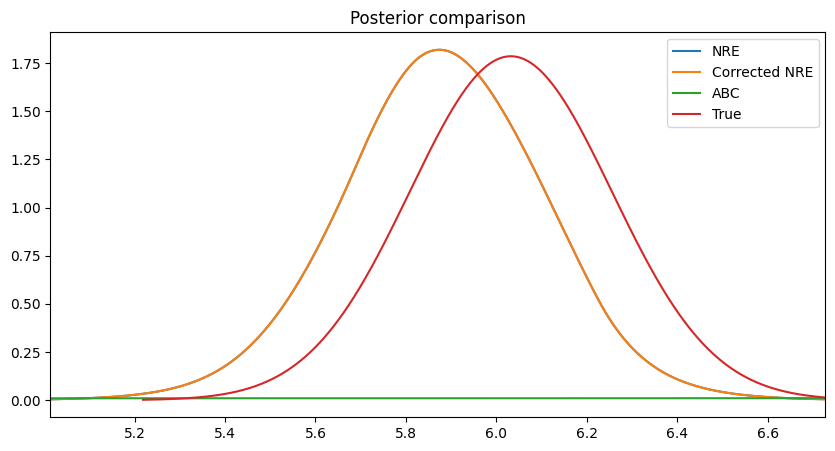

FIGURE CREATED at 
Evaluation of the metrics...
Finding grid...
New grid:  -32.905267314918945 32.90526731491926
Final grid:  5.013949 6.727826
Finding grid...
New grid:  -32.905267314918945 32.90526731491926
Final grid:  5.013949 6.727826

---------------------------------
DATASET 0 ALPHA 0.1
---------------------------------
Simulation of the training dataset...
Training the neural network...
Initial accuracy: 50.05%, Initial test accuracy: 50.02%
Training for 10 epochs...
Epoch 1/10, mean train accuracy: 78.09%, mean test accuracy: 83.72%, lr scale: 1.0 in 7.22 sec
Epoch 2/10, mean train accuracy: 83.55%, mean test accuracy: 81.40%, lr scale: 1.0 in 3.91 sec
Epoch 3/10, mean train accuracy: 83.83%, mean test accuracy: 84.21%, lr scale: 1.0 in 7.57 sec
Epoch 4/10, mean train accuracy: 83.82%, mean test accuracy: 84.05%, lr scale: 0.5 in 7.18 sec
Epoch 5/10, mean train accuracy: 84.11%, mean test accuracy: 84.03%, lr scale: 0.5 in 6.52 sec
Epoch 6/10, mean train accuracy: 84.19%, mean

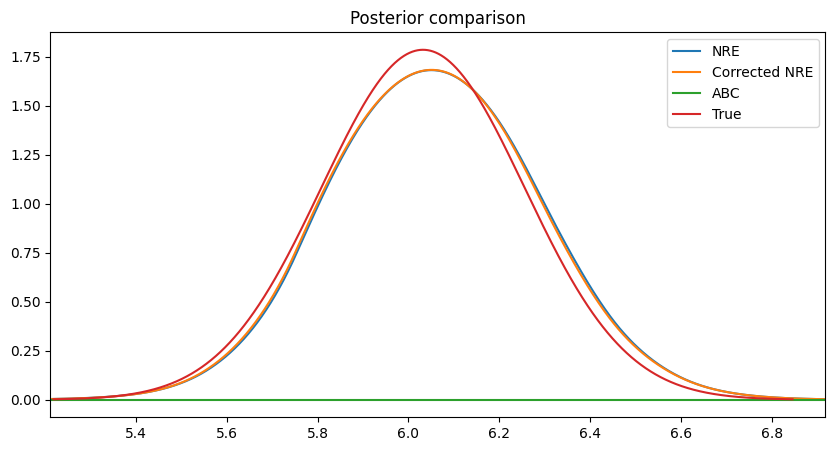

FIGURE CREATED at 
Evaluation of the metrics...
Finding grid...
New grid:  -32.905267314918945 32.90526731491926
Final grid:  5.212059 6.9180384
Finding grid...
New grid:  -32.905267314918945 32.90526731491926
Final grid:  5.212717 6.9107976

---------------------------------
DATASET 0 ALPHA 0.01
---------------------------------
Simulation of the training dataset...
Training the neural network...
Initial accuracy: 50.10%, Initial test accuracy: 49.94%
Training for 10 epochs...
Epoch 1/10, mean train accuracy: 50.12%, mean test accuracy: 50.05%, lr scale: 1.0 in 5.99 sec
Epoch 2/10, mean train accuracy: 50.23%, mean test accuracy: 49.96%, lr scale: 1.0 in 6.90 sec
Epoch 3/10, mean train accuracy: 49.88%, mean test accuracy: 50.07%, lr scale: 1.0 in 6.37 sec
Epoch 4/10, mean train accuracy: 50.03%, mean test accuracy: 49.92%, lr scale: 1.0 in 8.24 sec
Epoch 5/10, mean train accuracy: 49.96%, mean test accuracy: 50.07%, lr scale: 1.0 in 4.20 sec
Epoch 6/10, mean train accuracy: 50.03%, m

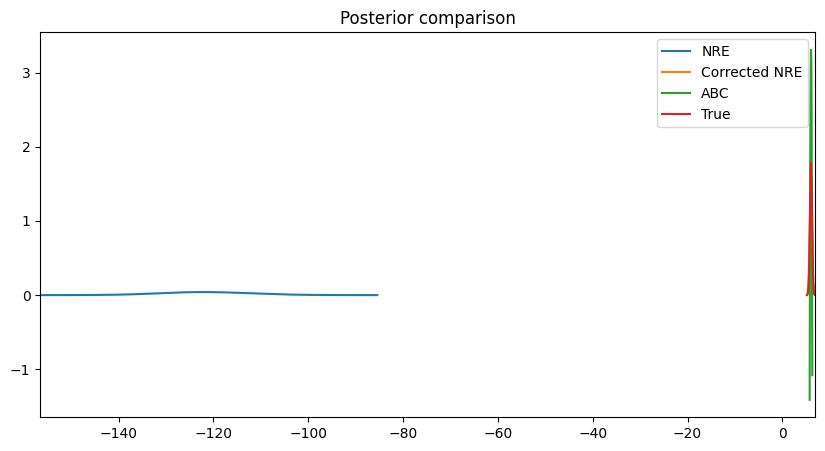

FIGURE CREATED at 
Evaluation of the metrics...
Finding grid...
New grid:  -39.48632077790276 32.90526731491926
New grid:  -46.725479587184964 32.90526731491926
New grid:  -54.68855427739538 32.90526731491926
New grid:  -63.44793643662685 32.90526731491926
New grid:  -73.08325681178145 32.90526731491926
New grid:  -83.68210922445152 32.90526731491926
New grid:  -95.3408468783886 32.90526731491926
New grid:  -108.1654582977194 32.90526731491926
New grid:  -122.27253085898326 32.90526731491926
New grid:  -137.7903106763735 32.90526731491926
New grid:  -154.8598684755028 32.90526731491926
New grid:  -154.8598684755028 32.90526731491926
Final grid:  -156.52174 -85.42676
Finding grid...
New grid:  -32.905267314918945 32.90526731491926
Final grid:  5.1541395 6.9233036
FIGURE CREATED at /Users/antoineluciano/Documents/Recherche/ABC-SBI/examples/Gauss-Gauss/Gauss_Gauss_1D_known_sigma/clean_results/sigma0_10/figures/c2st_0.png
FIGURE CREATED at /Users/antoineluciano/Documents/Recherche/ABC-SBI/

({1.0: [(Array([[ 0.18752061,  0.344434  ,  0.09431504, ..., -0.39322326,
             0.0610649 , -0.14256406],
           [ 0.04122071,  0.32731315, -0.28040153, ..., -0.23337224,
             0.06528969, -0.25640744],
           [ 0.33509174, -0.22004697,  0.4479393 , ..., -0.37937844,
             0.45961452, -0.1360076 ],
           ...,
           [-0.05005311, -0.00739385,  0.05394235, ...,  0.07233369,
             0.18757851, -0.14112611],
           [ 0.17627282, -0.22556126, -0.08913598, ..., -0.25233808,
             0.22617385,  0.06788059],
           [-0.063169  ,  0.3477475 ,  0.04547006, ..., -0.08816557,
            -0.00483041, -0.13543284]], dtype=float32),
    Array([ 1.90407768e-01,  4.95910704e-01,  2.95304041e-02, -2.08812468e-02,
           -1.49557844e-01, -1.62788946e-02,  3.00694734e-01, -1.12586677e-01,
            7.16556162e-02, -4.09483373e-01,  1.94118977e-01, -2.81963527e-01,
            3.28792483e-02,  7.39159733e-02,  1.61235511e-01,  3.82624492e-02

In [3]:
ALPHAS = [1., 0.1, .01]
key = random.PRNGKey(0)
for_a_dataset(0, key, N_POINTS, prior_simulator, data_simulator, discrepancy, ALPHAS, PRIOR_DIST, INDEX_MARGINAL)

In [6]:
key, key_data = random.split(key)
_, thetas_abc, _, _ = ABC_gauss(key_data, TRUE_DATA, EPSILON, 100000)

In [4]:
key = random.PRNGKey(0)
key, key_theta, key_data = random.split(key, 3)
TRUE_THETA = prior_simulator(key_theta)
TRUE_DATA = data_simulator(key_data, TRUE_THETA)
EPSILON = np.inf
index_marginal = 0
X,y, dists, params, train_accuracy, train_losses, test_accuracy, test_losses, key, time_simulations, time_training = ABC_NRE(key, N_POINTS, prior_simulator, data_simulator, discrepancy, TRUE_DATA, EPSILON, index_marginal)

Simulation of the training dataset...
Training the neural network...
Initial accuracy: 50.83%, Initial test accuracy: 50.49%
Training for 10 epochs...
Epoch 1/10, mean train accuracy: 93.29%, mean test accuracy: 97.27%, lr scale: 1.0 in 4.72 sec
Epoch 2/10, mean train accuracy: 97.27%, mean test accuracy: 97.96%, lr scale: 1.0 in 6.45 sec
Epoch 3/10, mean train accuracy: 97.68%, mean test accuracy: 97.61%, lr scale: 1.0 in 6.64 sec
Epoch 4/10, mean train accuracy: 97.87%, mean test accuracy: 98.30%, lr scale: 0.5 in 5.74 sec
Epoch 5/10, mean train accuracy: 97.95%, mean test accuracy: 97.68%, lr scale: 0.5 in 6.50 sec
Epoch 6/10, mean train accuracy: 98.30%, mean test accuracy: 98.73%, lr scale: 0.25 in 5.48 sec
Epoch 7/10, mean train accuracy: 98.69%, mean test accuracy: 98.81%, lr scale: 0.25 in 5.80 sec
Epoch 8/10, mean train accuracy: 98.65%, mean test accuracy: 98.86%, lr scale: 0.25 in 6.04 sec
Epoch 9/10, mean train accuracy: 98.82%, mean test accuracy: 98.74%, lr scale: 0.125 i

KDE...
Grid nre...
Finding grid...
New grid:  -38.9059188641312 38.9059188641312
Grid corrected nre...
Finding grid...
New grid:  -38.9059188641312 38.9059188641312
Grid kde...
Finding grid...
New grid:  -38.9059188641312 38.9059188641312
True posterior...


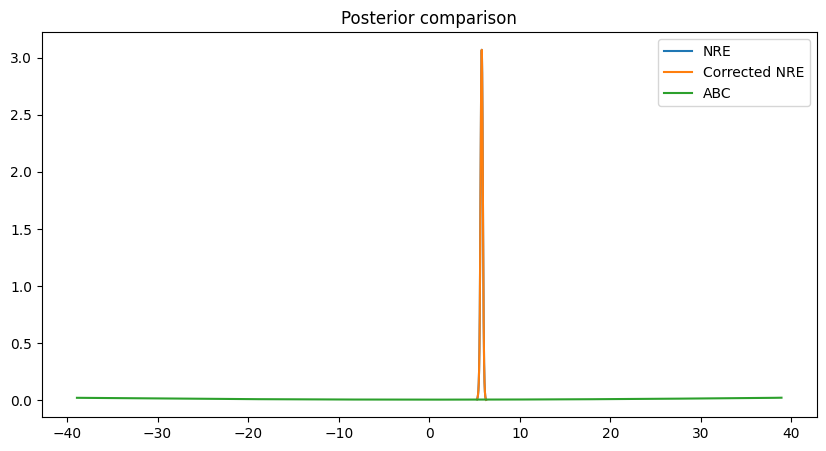

FIGURE CREATED at 


In [11]:
thetas_abc = X[:100000, 0]
from functions.plots import plot_posterior_comparison
plot_posterior_comparison(params, TRUE_DATA, thetas_abc.reshape(-1), PRIOR_DIST,  show = True, file_name = "")

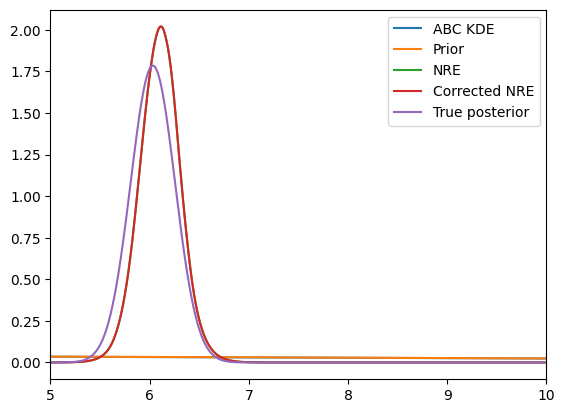

In [10]:
from scipy.stats import gaussian_kde 
import matplotlib.pyplot as plt
from functions.simulation import NRE_posterior_pdf, NRE_corrected_posterior_pdf
thetas_abc = thetas_abc.reshape(-1)[:100000]
kde_approx = gaussian_kde(thetas_abc.reshape(-1))
prior = norm(loc=MU0, scale=SIGMA0)
prior_logpdf = lambda x: prior.logpdf(x)
min_init, max_init = prior.interval(0.999)
x = np.linspace(min_init, max_init, 10000)
plt.plot(x, kde_approx(x), label = "ABC KDE")
plt.plot(x, prior.pdf(x), label = "Prior")
pdf_nre = NRE_posterior_pdf(params, x, TRUE_DATA, prior_logpdf)
pdf_corrected_nre = NRE_corrected_posterior_pdf(params, x, TRUE_DATA, kde_approx)
plt.plot(x, pdf_nre/np.trapz(pdf_nre, x), label = "NRE")
plt.plot(x, pdf_corrected_nre/np.trapz(pdf_corrected_nre, x), label = "Corrected NRE")
plt.plot(x, true_posterior_pdf(x, TRUE_DATA), label = "True posterior")
plt.xlim(5, 10)
plt.legend()
plt.show()

In [ ]:
from functions.simulation import find_grid_explorative
grid_nre_corrected, pdf_nre_corrected = find_grid_explorative(lambda x: NRE_corrected_posterior_pdf(params, x, TRUE_DATA, kde_approx), 10000, 10000, min_init, max_init)